# Breast Cancer Detection using CNN

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import glob
import PIL
import random

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import random
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from torch.optim.lr_scheduler import ReduceLROnPlateau

random.seed(100)

In [2]:
dicom_data = pd.read_csv('./dataset/cbis-ddsm-breast-cancer-image/csv/dicom_info.csv')
image_dir = './dataset/cbis-ddsm-breast-cancer-image/jpeg'

In [3]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [4]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [5]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [6]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images.head()

0     ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
3     ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
6     ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
7     ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
10    ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
Name: image_path, dtype: object

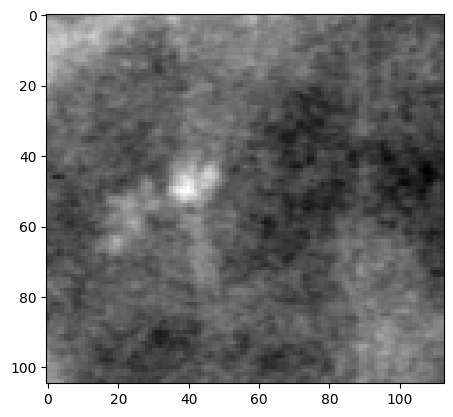

In [7]:
for file in cropped_images[0:10]:
    cropped_images_show = PIL.Image.open(file)
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [8]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [9]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.head()

1     ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
2     ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
11    ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
12    ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
15    ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
Name: image_path, dtype: object

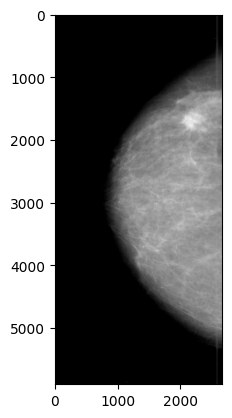

In [10]:
for file  in full_mammogram_images[0:10]:
    full_mammogram_images_show = PIL.Image.open(file)
    gray_img= full_mammogram_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [11]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [12]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images.head()

5     ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
8     ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
9     ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
14    ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
20    ./dataset/cbis-ddsm-breast-cancer-image/jpeg/1...
Name: image_path, dtype: object

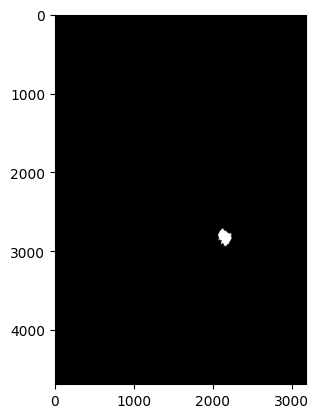

In [13]:
for file  in ROI_mask_images[0:10]:
    ROI_mask_images_show = PIL.Image.open(file)
    gray_img= ROI_mask_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

---

In [14]:
calc_case_df = pd.read_csv('./dataset/cbis-ddsm-breast-cancer-image/csv/calc_case_description_train_set.csv')

In [15]:
calc_case_df.head(5)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [16]:
mass_case_df = pd.read_csv('./dataset/cbis-ddsm-breast-cancer-image/csv/mass_case_description_train_set.csv')

In [17]:
mass_case_df.head(5)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


### Data Cleaning

In [18]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [19]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True) 

In [20]:
dicom_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [21]:
dicom_cleaned_data.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue        

In [22]:
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)

/var/folders/lf/zp435dsx7qzcjvt31lmwvp780000gn/T/ipykernel_63279/3809955931.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)


In [23]:
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

/var/folders/lf/zp435dsx7qzcjvt31lmwvp780000gn/T/ipykernel_63279/3223890453.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)


In [24]:
dicom_cleaned_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [25]:
Data_cleaning_1 = calc_case_df.copy()
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')
Data_cleaning_1.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [26]:
Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1.isna().sum()

/var/folders/lf/zp435dsx7qzcjvt31lmwvp780000gn/T/ipykernel_63279/2703319416.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
/var/folders/lf/zp435dsx7qzcjvt31lmwvp780000gn/T/ipykernel_63279/2703319416.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)


patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [27]:
Data_cleaning_2 = mass_case_df.copy()
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [28]:
Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2.isna().sum()

/var/folders/lf/zp435dsx7qzcjvt31lmwvp780000gn/T/ipykernel_63279/73198642.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
/var/folders/lf/zp435dsx7qzcjvt31lmwvp780000gn/T/ipykernel_63279/73198642.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)


patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

---

### Data Visualization

In [29]:
breast_imgs = glob.glob('./dataset/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [30]:
for imgname in breast_imgs[:5]:
    print(imgname)

./dataset/breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png
./dataset/breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png
./dataset/breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png
./dataset/breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3051_y801_class0.png
./dataset/breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x951_y1901_class0.png


In [31]:
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0' :
        non_cancer_imgs.append(img)
    
    elif img[-5] == '1' :
        cancer_imgs.append(img)

In [32]:
non_cancer_num = len(non_cancer_imgs)  # No cancer
cancer_num = len(cancer_imgs)   # Cancer 
        
total_img_num = non_cancer_num + cancer_num
        
print('Number of Images of no cancer: {}' .format(non_cancer_num))   # images of Non cancer
print('Number of Images of cancer : {}' .format(cancer_num))   # images of cancer 
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 198738
Number of Images of cancer : 78786
Total Number of Images : 277524


In [33]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [198738,78786]})

In [34]:
bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
bar.update_layout(title_text='Number of Patients with cancer (1) and patients with no cancer (0)', title_x=0.5)
bar.show()

In [35]:
r= pd.DataFrame(dicom_cleaned_data['SeriesDescription'].value_counts())
r= r.reset_index()
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
r

,SeriesDescription_counts,count
0,cropped images,3859
1,ROI mask images,3340
2,full mammogram images,3038


In [36]:
ba_1 = px.bar(data_frame=dicom_cleaned_data, x='SeriesDescription', color='SeriesDescription',
              title='Types of images used')
ba_1.update_layout(title_text='Types of images used', title_x=0.5)
ba_1.show()

from cbis-ddsm-breast-cancer-image-dataset : This study depends on Three types of images ; `cropped images` , `ROI images` , `Full mammogram images` . from this graph we conclude that `cropped images` is the most used between them

In [37]:
f= pd.DataFrame(dicom_cleaned_data['BodyPartExamined'].value_counts())
f= f.reset_index()
f= f.rename(columns={'BodyPartExamined':'BodyPartExamined_counts', 'index':'Breast part Examined'})
f

,BodyPartExamined_counts,count
0,BREAST,9671
1,Left Breast,318
2,Right Breast,248


In [38]:
ba = px.bar(data_frame=f, x="BodyPartExamined_counts", y="count", color="BodyPartExamined_counts")
ba.update_layout(title_text='Breast Parts Examined', title_x=0.5, yaxis=dict(type='log'))
ba.show()

**The Most Part Examined is Breast "All" = left and also right**

In [39]:
data_insight_2 = pd.DataFrame({'abnormality':[Data_cleaning_1.abnormality_type[0],Data_cleaning_2.abnormality_type[0]],
                               'counts_of_abnormalties':[len(Data_cleaning_1),len(Data_cleaning_2)]})
data_insight_2

,abnormality,counts_of_abnormalties
0,calcification,1546
1,mass,1318


In [40]:
bar_2 =px.bar(data_frame=data_insight_2, x = 'abnormality', y='counts_of_abnormalties', color = 'abnormality')
bar_2.update_layout(title_text='Types of abnormalites of cancer', title_x=0.5)
bar_2.show()

from this graph: 
There are two abnormalities of breast cancer:
- Calcification abnormality
- Mass abnormality 

**Most cases are with calcification abnormalities**

In [41]:
x = Data_cleaning_1.left_or_right_breast.value_counts().RIGHT
y = Data_cleaning_1.left_or_right_breast.value_counts().LEFT
print(x,y)

728 818


In [42]:
data_insight_3 = pd.DataFrame({'left_or_right_breast':['RIGHT','LEFT'] , 'Counts':[x,y]})
data_insight_3

,left_or_right_breast,Counts
0,RIGHT,728
1,LEFT,818


In [43]:
insight_3 = px.bar(data_insight_3, y= 'Counts', x='left_or_right_breast',color = 'left_or_right_breast')
insight_3.update_layout(title_text=' clacification cancer position of the breasts ', title_x=0.5)
insight_3.show()

**For calcification cancer, most cases are usually in the left breast.**

In [44]:
z = pd.DataFrame(Data_cleaning_1['calc_type'].value_counts())
z = z.reset_index()
z= z.rename(columns={'calc_type':'calc_type_counts'})
z

,calc_type_counts,count
0,PLEOMORPHIC,664
1,AMORPHOUS,139
2,PUNCTATE,106
3,LUCENT_CENTER,93
4,VASCULAR,82
5,FINE_LINEAR_BRANCHING,77
6,COARSE,35
7,ROUND_AND_REGULAR-LUCENT_CENTER,33
8,PLEOMORPHIC-FINE_LINEAR_BRANCHING,28
9,ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE,24


**Calcification cancer has 45 types, the majority of which are PLEOMORPHIC.**

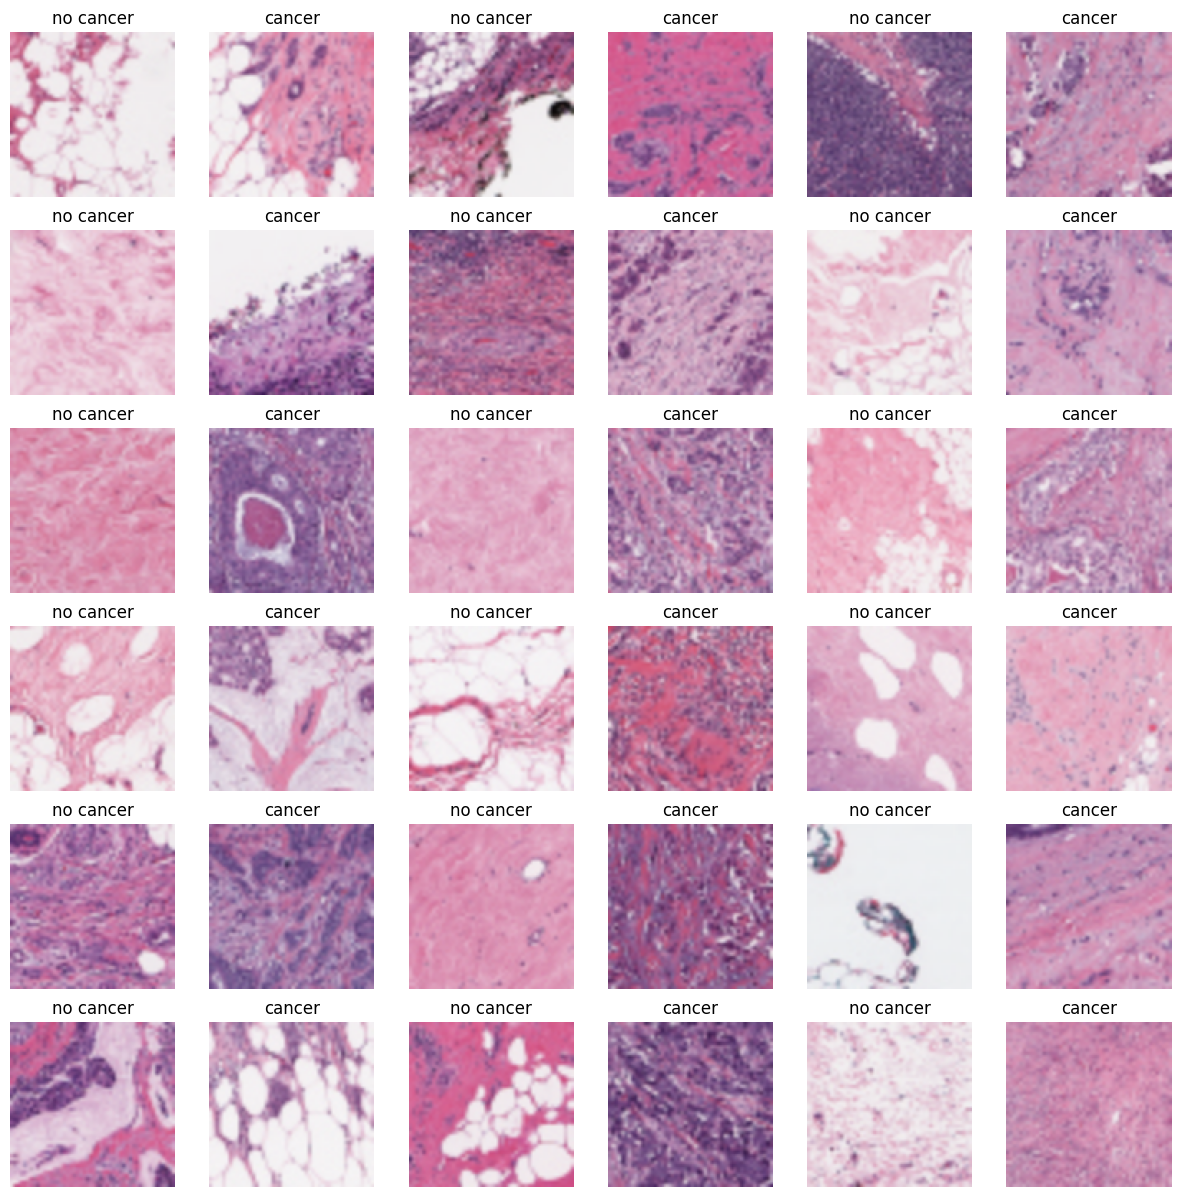

In [45]:
import torch
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((100, 100), antialias=False),
    transforms.ConvertImageDtype(torch.uint8)
])

plt.figure(figsize=(15, 15))

# Randomly select images from non-cancer and cancer datasets
some_non = np.random.randint(0, len(non_cancer_imgs), 18)
some_can = np.random.randint(0, len(cancer_imgs), 18)

# Display non-cancer images
s = 0
for num in some_non:
    img_path = non_cancer_imgs[num]
    img = read_image(img_path)
    img = transform(img)

    plt.subplot(6, 6, 2*s+1)
    plt.axis('off')
    plt.title('no cancer')
    plt.imshow(img.permute(1, 2, 0))  # Permute to rearrange the dimensions
    s += 1

# Display cancer images
s = 1
for num in some_can:
    img_path = cancer_imgs[num]
    img = read_image(img_path)
    img = transform(img)

    plt.subplot(6, 6, 2*s)
    plt.axis('off')
    plt.title('cancer')
    plt.imshow(img.permute(1, 2, 0))  # Permute to rearrange the dimensions
    s += 1

plt.show()

---
### Data Modeling

In [46]:
# Randomly sample images from two lists, 'non_cancer_imgs' and 'cancer_imgs'
some_non_img = random.sample(non_cancer_imgs, len(non_cancer_imgs))
some_can_img = random.sample(cancer_imgs, len(cancer_imgs))

# Initialize empty arrays to store image data and labels
non_img_arr = []  # Array for non-cancer images
can_img_arr = []  # Array for cancer images

# Loop through each image in the 'some_non_img' list
for img in some_non_img:
    # Read the image in color mode
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 0 (indicating non-cancer) to the 'non_img_arr'
    non_img_arr.append([n_img_size, 0])

# Loop through each image in the 'some_can_img' list
for img in some_can_img:
    # Read the image in color mode
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 1 (indicating cancer) to the 'can_img_arr'
    can_img_arr.append([c_img_size, 1])

In [47]:
X = []  # List for image data
y = []  # List for labels

# Concatenate the arrays 'non_img_arr' and 'can_img_arr' into a single array 'breast_img_arr'
breast_img_arr = non_img_arr + can_img_arr

# Shuffle the elements in the 'breast_img_arr' array randomly
random.shuffle(breast_img_arr)

# Loop through each element (feature, label) in the shuffled 'breast_img_arr'
for feature, label in breast_img_arr:
    # Append the image data (feature) to the 'X' list
    X.append(feature)
    # Append the label to the 'y' list
    y.append(label)

# Convert the lists 'X' and 'y' into NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shape of the 'X' array
print('X shape: {}'.format(X.shape))

X shape: (277524, 50, 50, 3)


In [48]:
# Convert the labels to one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
y_reshaped = y.reshape(len(y), 1)
y_onehot = onehot_encoder.fit_transform(y_reshaped)

# Split the dataset into training and testing sets, with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.20, random_state=42)

print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (222019, 50, 50, 3)
X_test shape : (55505, 50, 50, 3)
y_train shape : (222019, 2)
y_test shape : (55505, 2)


In [49]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [50]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-7, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.best_loss = None
        self.epochs_no_improve = 0
        self.should_stop = False
        self.best_weights = None
    
    def step(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
            self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print("Early stopping triggered")
                model.load_state_dict(self.best_weights)

In [51]:
# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
])

# Create the datasets
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the size of the validation set
validation_size = int(len(train_dataset) * 0.2)  # 20% of dataset is for validation
training_size = len(train_dataset) - validation_size

# Randomly split the training dataset into new training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [training_size, validation_size])

# Now, you create DataLoaders for the new training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Calculate the mean and std for normalization later during prediction.

In [52]:
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.7335, 0.6343, 0.8132])
Std: tensor([0.1077, 0.1449, 0.0914])


In [53]:
# Define the model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define the layers in the same sequence as in the Keras model
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*2*2, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)

    def _forward_features(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = self.flatten(x)
        
				# Relu on the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [54]:
mps = torch.device("mps")

Model = Model()
Model.float()
Model = Model.to(mps)

In [55]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=0.001)

In [56]:
early_stopping = EarlyStopping(patience=5, min_delta=1e-7, verbose=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

In [57]:
from tqdm import tqdm

epochs = 2 # should be 25

# Prepare lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
	train_loss = 0.0
	correct_train = 0
	total_train = 0
	# Put the model in training mode
	Model.train()
	
	# Initialize tqdm progress bar
	train_loader = tqdm(train_loader)
	for i, (inputs, labels) in enumerate(train_loader, 0):
		inputs = inputs.to(mps)
		labels = labels.float().to(mps)
		
		optimizer.zero_grad()
		outputs = Model(inputs)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()
		
		train_loss += loss.item()
		labels = torch.argmax(labels, dim=1)
		_, predicted = torch.max(outputs.data, 1)
		total_train += labels.size(0)
		correct_train += (predicted == labels).sum().item()
		# Update progress bar
		train_loader.set_description(f'Epoch {epoch+1}')
		train_loader.set_postfix(loss=loss.item())
	
	# Calculate average training loss and accuracy over the epoch
	avg_train_loss = train_loss / len(train_loader)
	train_accuracy = correct_train / total_train
	train_losses.append(avg_train_loss)
	train_accuracies.append(train_accuracy)
	
	# Validation phase
	Model.eval()  # Put the model in evaluation mode
	val_loss = 0.0
	correct_val = 0
	total_val = 0
	with torch.no_grad():
		for inputs, labels in test_loader:
			inputs = inputs.to(mps)
			labels = labels.float().to(mps)

			outputs = Model(inputs)
			loss = criterion(outputs, labels)
			val_loss += loss.item()
			labels = torch.argmax(labels, dim=1)
			_, predicted = torch.max(outputs.data, 1)
			total_val += labels.size(0)
			correct_val += (predicted == labels).sum().item()

	# Calculate average validation loss over the epoch
	avg_val_loss = val_loss / len(test_loader)
	val_accuracy = correct_val / total_val
	val_losses.append(avg_val_loss)
	val_accuracies.append(val_accuracy)
	
	# Step the scheduler with the average validation loss
	scheduler.step(avg_val_loss)

	# Early Stopping step with the average validation loss
	early_stopping.step(avg_val_loss, Model)

	# Print statistics
	print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

	if early_stopping.should_stop:
		print("Stopping early due to no improvement in validation loss.")
		break


Epoch 1: 100%|██████████| 5551/5551 [02:01<00:00, 45.76it/s, loss=0.376] 


Epoch 1, Training Loss: 0.3369574574637877, Validation Loss: 0.3994410730404538


Epoch 2: 100%|██████████| 5551/5551 [01:57<00:00, 47.08it/s, loss=0.17]  


Epoch 2, Training Loss: 0.30399521062705265, Validation Loss: 0.28377299575022386


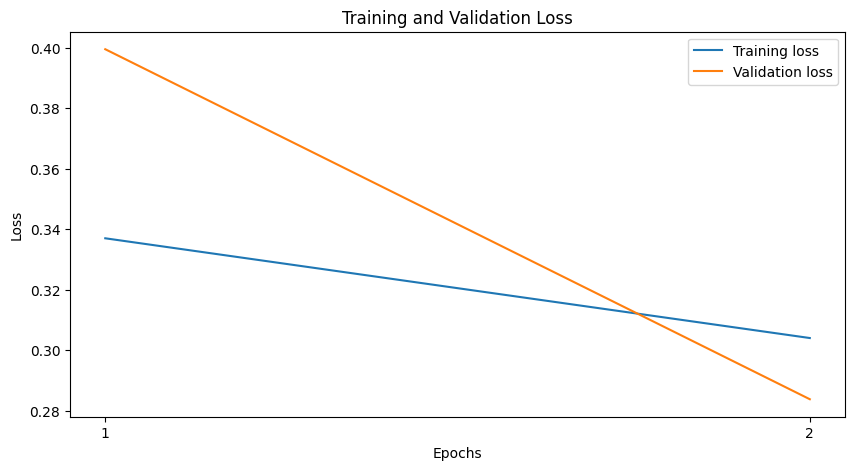

In [58]:
# Plot training and validation loss
epochs_range = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(10,5))

plt.plot(epochs_range, train_losses, label='Training loss')
plt.plot(epochs_range, val_losses, label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(epochs_range)
plt.legend()
plt.show()

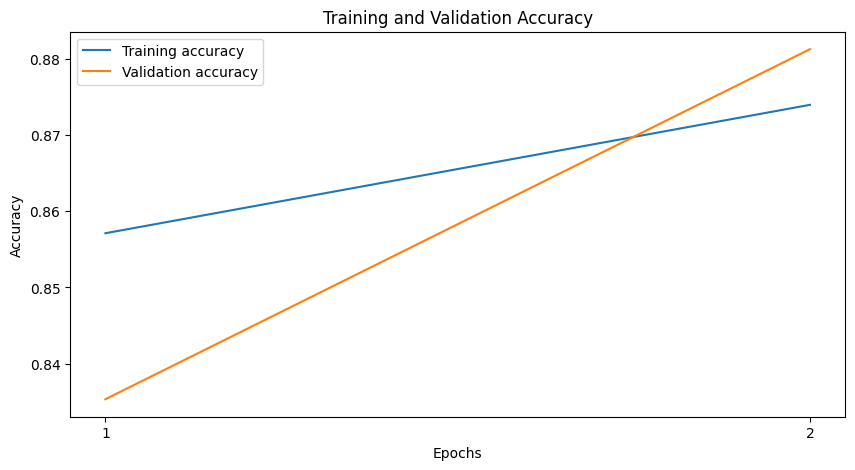

In [59]:
# Plot training and validation accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies, label='Training accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.xticks(epochs_range)
plt.legend()
plt.show()

In [60]:
# Evaluation
correct = 0
total = 0
all_labels = []
all_preds = []

Model.eval()
with torch.no_grad():
    for (images, labels) in test_loader:
        images = images.to(mps)
        labels = labels.float()
        labels = labels.to(mps)
        outputs = Model(images)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels)
        all_preds.extend(predicted)

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 88 %


In [61]:
# Convert lists of tensors to a single tensor, then move to CPU and convert to NumPy
all_labels_tensor = torch.stack(all_labels).cpu().numpy()
all_preds_tensor = torch.stack(all_preds).cpu().numpy()


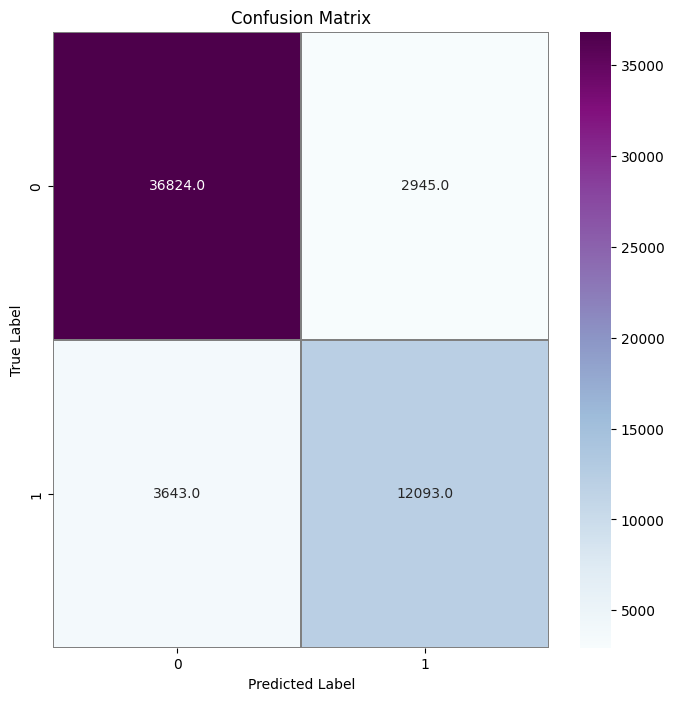

In [62]:
cm = confusion_matrix(all_labels_tensor, all_preds_tensor)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Testing the Model

In [63]:
# Define a mapping of class indices to human-readable labels
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}

# Define a mapping of calcification types
calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}

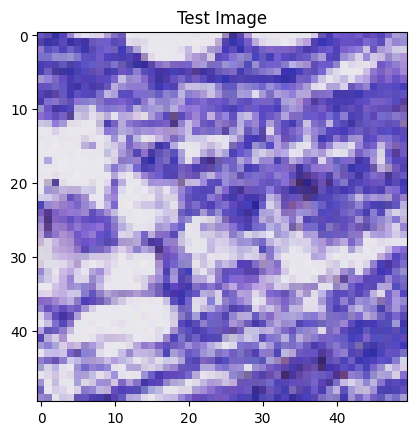

Predicted Diagnosis: Non-Cancerous
Calcification Type: No Calcification
True Diagnosis: Non-Cancerous


In [64]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Define a function for plotting an image from a tensor
def img_plot(array, index=0):
	plt.title('Test Image')
	plt.imshow(array[index])
	plt.show()

# Set the index value to 90
index = 90

img_plot(X_test, index)

# Convert the test image to a PyTorch tensor and add a batch dimension with `unsqueeze`
input_tensor = torch.from_numpy(X_test[index]).unsqueeze(0)

# If your PyTorch model expects input with channels first, permute the dimensions
input_tensor = input_tensor.permute(0, 3, 1, 2).float()

# Set model to evaluation mode
Model.eval()
cpu = torch.device("cpu")
Model.to(cpu)

# Make a prediction using the PyTorch model
with torch.no_grad():
	output = Model(input_tensor)
	predicted_class_index = output.argmax(dim=1).item()

# Get the true label from the y_test array
true_class_index = y_test[index].argmax()

# Get the predicted and true labels from the mappings
predicted_label = class_labels[predicted_class_index]
true_label = class_labels[true_class_index]

# Get the calcification type based on the predicted class index
calcification_type = calcification_types[predicted_class_index]

# Print the prediction result with calcification type
print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label)

#### Saving the model

In [68]:
# Save the model state
model_path = 'model_state.pth'
torch.save(Model.state_dict(), model_path)

# If you want to save the optimizer state as well
checkpoint = {
	'model_state_dict': Model.state_dict(),
	'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, 'model_checkpoint.pth')

### Testing the Model on MINI DDSM Dataset

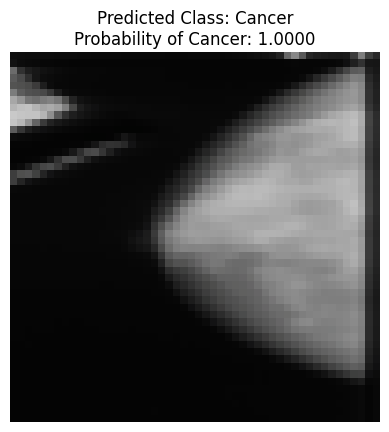

In [69]:
# Load the model
Model.load_state_dict(torch.load('./model_state.pth'))
Model.eval()  # Set the model to evaluation mode
# Directory containing the images
imgs_dir = glob.glob('./dataset/MINI-DDSM-Complete-JPEG-8/Benign/**/*.jpeg', recursive=True)

# Example image path
image_path = './dataset/MINI-DDSM-Complete-JPEG-8/Normal/0002/A_0002_1.LEFT_CC.jpg'

# Define a function to load and preprocess an image
def load_and_preprocess_image(image_path, mean, std,target_size=(50, 50)):
	try:
		# Load and preprocess the image
		img = PIL.Image.open(image_path).convert('RGB')
		preprocess = transforms.Compose([
				transforms.Resize(target_size),
				transforms.ToTensor(),
				transforms.Normalize(mean, std),
		])
		img_t = preprocess(img)
		return img_t
	except Exception as e:
		print(f"Error processing {image_path}: {str(e)}")
		return None

# Load and preprocess the example image
img_tensor = load_and_preprocess_image(image_path, mean, std)

if img_tensor is not None:
	# Create a batch for prediction (even if it's a single image)
	img_batch = img_tensor.unsqueeze(0)  # PyTorch models expect a batch dimension

	# Make predictions
	with torch.no_grad():  # No need to compute gradients (for memory efficiency)
			outputs = Model(img_batch)

	# Convert outputs into probabilities using softmax
	probabilities = torch.softmax(outputs, dim=1)

	# Get the probability for the "Cancer" class
	cancer_probability = probabilities[0][0].item()  # Cancer is the first class

	# Get the predicted class label
	predicted_class = "Cancer" if cancer_probability >= 0.5 else "Normal"

	# Convert the tensor to a NumPy array for plotting
	img_array = img_tensor.numpy().transpose(1, 2, 0)
	img_array = std * img_array + mean  # Denormalize
	img_array = np.clip(img_array, 0, 1)  # Clip to ensure valid image range

	# Plot the image and display the predicted class and probability
	plt.imshow(img_array)
	plt.title(f'Predicted Class: {predicted_class}\nProbability of Cancer: {cancer_probability:.4f}')
	plt.axis('off')
	plt.show()
else:
	print("Image loading and preprocessing failed.")
